# Q: How easy would it be to use OceanParcels to analyse convective plumes in a very high-resolution non-hydrostatic model?

Rowan Brown | 19.02.2025

Following this quickstart guide: https://docs.oceanparcels.org/en/latest/examples/parcels_tutorial.html

Imports:

In [1]:
import math
from datetime import timedelta
from operator import attrgetter

from xmitgcm import open_mdsdataset 
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import basic_model_anayses as bma
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

import parcels
from parcels.tools import StatusCode
from parcels import ParcelsRandom

Going from MITgcm binaries to a parcels FieldSet:

In [17]:
filepath = '../MITgcm/so_plumes/mrb_024/' # Example model output
ds = bma.open_mitgcm_output_all_vars(filepath) # Open the data
display(ds) # Inspect the data

<xarray.Dataset> Size: 6GB
Dimensions:  (XC: 100, YC: 100, XG: 100, YG: 100, Z: 50, Zp1: 51, Zu: 50,
              Zl: 50, time: 481)
Coordinates: (12/34)
  * XC       (XC) >f4 400B 10.0 30.0 50.0 70.0 ... 1.95e+03 1.97e+03 1.99e+03
  * YC       (YC) >f4 400B 10.0 30.0 50.0 70.0 ... 1.95e+03 1.97e+03 1.99e+03
  * XG       (XG) >f4 400B 0.0 20.0 40.0 60.0 ... 1.94e+03 1.96e+03 1.98e+03
  * YG       (YG) >f4 400B 0.0 20.0 40.0 60.0 ... 1.94e+03 1.96e+03 1.98e+03
  * Z        (Z) >f4 200B -0.2 -1.0 -2.6 -5.0 ... -865.0 -902.6 -941.0 -980.2
  * Zp1      (Zp1) >f4 204B 0.0 -0.4 -1.6 -3.6 ... -883.6 -921.6 -960.4 -1e+03
    ...       ...
    dxV      (YG, XG) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    rhoRef   (Z) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    dyF      (YC, XC) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    dyU      (YG, XG) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    dxF      (YC, XC) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    iter     (time) float64 4kB dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    U        (time, Z, YC, XG) float32 962MB dask.array<chunksize=(1, 50, 100, 100), meta=np.ndarray>
    V        (time, Z, YG, XC) float32 962MB dask.array<chunksize=(1, 50, 100, 100), meta=np.ndarray>
    W        (time, Zl, YC, XC) float32 962MB dask.array<chunksize=(1, 50, 100, 100), meta=np.ndarray>
    S        (time, Z, YC, XC) float32 962MB dask.array<chunksize=(1, 50, 100, 100), meta=np.ndarray>
    Eta      (time, YC, XC) float32 19MB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    T        (time, Z, YC, XC) float32 962MB dask.array<chunksize=(1, 50, 100, 100), meta=np.ndarray>
    PH       (time, Z, YC, XC) float32 962MB dask.array<chunksize=(1, 50, 100, 100), meta=np.ndarray>
    PHL      (time, YC, XC) float32 19MB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir=None, iters=No...

Defining 3D fieldsets

In [18]:

variables = {"U": "U", "V": "V", "W": "W"} # Mapping model variable names to parcels (they're the same)
dimensions = { # Mapping dimension names; they're different for different variables due to the c-grid
    "U": {"lon": "XG", "lat": "YC", "depth": "Z", "time": "time"},
    "V": {"lon": "XC", "lat": "YG", "depth": "Z", "time": "time"},
    "W": {"lon": "YC", "lat": "YC", "depth": "Zl", "time": "time"},
}
fieldset = parcels.FieldSet.from_xarray_dataset(ds,variables,dimensions) # Creating the fieldset

# Adding Kh values
fieldset.add_constant_field("Kh_zonal", 0.04, mesh='flat')
fieldset.add_constant_field("Kh_meridional", 0.04, mesh='flat')
fieldset.add_constant_field("Kh_vertical", 0.04, mesh='flat')


Making some custom kernels:

In [20]:
# First two kernels are for handling particles that hit the boundary and cause crashing
def DeleteParticle(particle, fieldset, time):
    particle.delete()

def DeleteErrorParticle(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds:
        particle.delete()

def DiffusionUniformKh_3D(particle, fieldset, time):  # Copied from the source code (2D) and extended to 3D
    """Kernel for simple 2D diffusion where diffusivity (Kh) is assumed uniform.

    Assumes that fieldset has constant fields `Kh_zonal` and `Kh_meridional`.
    These can be added via e.g.
    `fieldset.add_constant_field("Kh_zonal", kh_zonal, mesh=mesh)`
    or
    `fieldset.add_constant_field("Kh_meridional", kh_meridional, mesh=mesh)`
    where mesh is either 'flat' or 'spherical'

    This kernel assumes diffusivity gradients are zero and is therefore more efficient.
    Since the perturbation due to diffusion is in this case isotropic independent, this
    kernel contains no advection and can be used in combination with a separate
    advection kernel.

    The Wiener increment `dW` is normally distributed with zero
    mean and a standard deviation of sqrt(dt).
    """
    # Wiener increment with zero mean and std of sqrt(dt)
    dWx = ParcelsRandom.normalvariate(0, math.sqrt(math.fabs(particle.dt)))
    dWy = ParcelsRandom.normalvariate(0, math.sqrt(math.fabs(particle.dt)))
    dWz = ParcelsRandom.normalvariate(0, math.sqrt(math.fabs(particle.dt)))    

    bx = math.sqrt(2 * fieldset.Kh_zonal[particle])
    by = math.sqrt(2 * fieldset.Kh_meridional[particle])
    bz = math.sqrt(2 * fieldset.Kh_vertical[particle])

    particle_dlon += bx * dWx  # noqa
    particle_dlat += by * dWy  # noqa
    particle_dlat += bz * dWz  # noqa

Defining a particle set and executing:

In [21]:
# Creating the particles
coords1D = np.linspace(300,1600,2)
coords2D_X,coords2D_Y = np.meshgrid(coords1D,coords1D)
coords2D_X_flattened, coords2D_Y_flattened = coords2D_X.flatten(), coords2D_Y.flatten()
depths = np.full(np.shape(coords2D_X_flattened),-400) # Doesn't matter which coords2D you use
pset = parcels.ParticleSet( fieldset=fieldset, lon = coords2D_X_flattened, lat = coords2D_Y_flattened, depth = depths)

# Specifying the kernels; I find that diffusion is necessary
kernels = pset.Kernel(parcels.AdvectionRK4_3D)+pset.Kernel(DiffusionUniformKh_3D)+pset.Kernel(DeleteErrorParticle)

output_file = pset.ParticleFile( name="parcels_particles.zarr", outputdt=timedelta(minutes=3) ) # Ouput is every 3 minutes
pset.execute( kernels, runtime=timedelta(hours=8), dt=timedelta(minutes=3), output_file=output_file) # You can play with dt


INFO: Output files are stored in parcels_particles.zarr.
100%|██████████| 28800.0/28800.0 [00:06<00:00, 4447.38it/s]


Throwing together a plot:

0
1
2
3


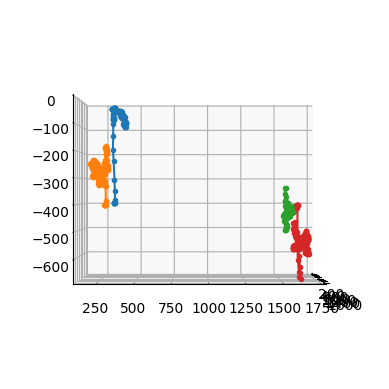

In [22]:
ds = xr.open_zarr("parcels_particles.zarr",decode_cf=False) # Open the particles

ax = plt.figure().add_subplot(projection='3d') # Init

# Uncomment it you want one particle
#da = ds.isel(trajectory=2) 
#ax.plot(da.lon.T, da.lat.T, da.z.T, ".-")

# Plot particles in a loop
for i in range(len(ds['trajectory'])):
    print(i)
    da = ds.isel(trajectory=i)
    ax.plot(da.lon.T, da.lat.T, da.z.T, ".-")

# Parameters for manipulating the plot
ax.view_init(0, 0, 0)
#ax.set_ylim(0,2000)
#ax.set_xlim(0,2000)
#ax.set_zlim(-1000,0)
#plt.xlabel("Zonal distance [m]")
#plt.ylabel("Meridional distance [m]")

plt.show()

